# 0. BITAmin Review Project
* goal: Loan approval prediction model 
* data: https://www.kaggle.com/vipin20/loan-application-data

# 1. Load

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('loan.csv')
df.head()

,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,$5849.0
1,1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,$6091.0
2,2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,$3000.0
3,3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,$4941.0
4,4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,$6000.0


# 2. Preprocessing

### 기본 작업

In [3]:
# 불필요한 features 삭제
df = df.drop(['Unnamed: 0', 'Loan_ID'], axis=1)

# Total_Income 변환
for i in range(len(df['Total_Income'])):
    df['Total_Income'][i] = float(df['Total_Income'][i].strip('$'))
df['Total_Income'] = df['Total_Income'].astype(float)

# Credit_History 변환
df['Credit_History'] = df['Credit_History'].astype(object)

# features/label 분리
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

# 종속변수 인코딩
y.replace(to_replace={'N':0, 'Y':1}, inplace=True)

# 연속형 피처 리스트 저장
num_col = list(X._get_numeric_data().columns)

# 범주형 피처 리스트 저장
cat_col = list(X.columns)
for col in num_col:
    cat_col.remove(col)

### 결측치 처리

In [4]:
# 연속형 데이터 결측값 처리: 평균값으로 채우기
for col in num_col:
    X[col].fillna(round(np.mean(X[col])), inplace=True)
    
# 범주형 데이터 결측값 처리: 최빈값으로 채우기
for col in cat_col:
    X[col].fillna(X[col].mode()[0], inplace=True)

### 스케일링

In [5]:
# np.log1p
for num in num_col:
    X[num] = np.log1p(X[num])  
    
# StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[num_col])
X_scaled_df = pd.DataFrame(data=X_scaled, columns=num_col)
X.drop(num_col, axis=1, inplace=True)
X = pd.concat([X, X_scaled_df], axis=1)

### 인코딩

In [6]:
# 레이블 인코딩
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for cat in cat_col:
    X[cat] = encoder.fit_transform(X[cat])

### 불균형 데이터 처리

In [7]:
# RandomOverSampling
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

randomsample= RandomOverSampler()
X, y = randomsample.fit_sample(X, y)

# 3. Modeling

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [9]:
# train/test set 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

In [10]:
# StratifiedKFold 함수 정의
def kFold(model):
    n_fold = 11

    skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=2)
    folds = []
    acc_list = []

    for train_idx, validate_idx in skfold.split(X, y):
        folds.append((train_idx, validate_idx))

    for fold in range(n_fold):
        train_idx, validate_idx = folds[fold]
        X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[validate_idx], y[train_idx], y[validate_idx]

        kf_model = model
        kf_model.fit(X_train, y_train)

        y_preds = kf_model.predict(X_valid)
        accuracy = accuracy_score(y_valid, y_preds)
        acc_list.append(accuracy)

    return np.mean(acc_list)

In [11]:
# 평가 지표 함수
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('\n정확도: {0:.4f}\n정밀도: {1:.4f}\n재현율: {2:.4f}\nF1: {3:.4f}\nROC: {3:.4f}'.format(accuracy, precision, recall, f1, roc_score))

In [12]:
# 모델 정의
models = [
          # DeacisionTree
          DecisionTreeClassifier(min_samples_split=3, random_state=2),
    
          # KNN
          KNeighborsClassifier(n_neighbors=3),
    
          # Naive Bayes
          GaussianNB(),
    
          # Logistic Regression
          LogisticRegression(random_state=2),
    
          # SVC
          SVC(C = 0.04,
              gamma = 'scale',
              kernel = 'linear',
              decision_function_shape = 'ovo',
              probability = True,
              shrinking = True,
              random_state = 2),
    
          # RandomForest
          RandomForestClassifier(random_state=2),
    
          # XGBoost
          XGBClassifier(learning_rate =0.002,
                       n_estimators=1000,
                       max_depth=6,
                       min_child_weight=1,
                       gamma=0.2,
                       subsample=0.69,
                       colsample_bytree=0.8,
                       objective= 'binary:logistic',
                       nthread=-1,
                       scale_pos_weight=1,
                       reg_alpha=1e-5,
                       random_state=2,
                       verbose=False),
    
          # LightGBM
          LGBMClassifier(n_estimators=1000,
                         learning_rate=0.04,
                         num_leaves=15,
                         random_state=2),
          # CatBoost
          CatBoostClassifier(n_estimators=1000, random_state=2, verbose=False)]

In [13]:
# model fitting - kfold X
for model in models:
    fit = model.fit(X_train, y_train)
    preds = fit.predict(X_test)
    score = accuracy_score(y_test, preds)
    print(model.__class__.__name__,' : ', score)

DecisionTreeClassifier  :  0.884393063583815
KNeighborsClassifier  :  0.7976878612716763
GaussianNB  :  0.6936416184971098
LogisticRegression  :  0.6936416184971098
SVC  :  0.6994219653179191
RandomForestClassifier  :  0.8786127167630058
XGBClassifier  :  0.8092485549132948
LGBMClassifier  :  0.8728323699421965
CatBoostClassifier  :  0.8786127167630058


In [14]:
# model fitting - kfold O
for model in models:
    print(model.__class__.__name__,' : ', kFold(model))

DecisionTreeClassifier  :  0.8609132802681191
KNeighborsClassifier  :  0.7652329749103942
GaussianNB  :  0.6940604198668715
LogisticRegression  :  0.6882651398780432
SVC  :  0.7012754270818786
RandomForestClassifier  :  0.9086952474049248
XGBClassifier  :  0.7999813806265419
LGBMClassifier  :  0.9159335288367546
CatBoostClassifier  :  0.8754596657822464


# 4. Final Model

### RandomForest + Stratified K-Fold O

In [15]:
n_fold = 11; cv_acc = []
folds = StratifiedKFold(n_splits=11, shuffle=True, random_state=2)

for n_fold, (train_index, test_index)  in enumerate(folds.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    final = RandomForestClassifier(random_state=2)
    final.fit(X_train, y_train)
    pred = final.predict(X_test)
    pred_proba = final.predict_proba(X_test)
    acc = accuracy_score(y_test, pred)
    cv_acc.append(acc)

print('교차 검증 평균 정확도: ', round(np.mean(cv_acc), 4)) 

교차 검증 평균 정확도:  0.9087


In [16]:
get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[30  1]
 [ 3 28]]

정확도: 0.9355
정밀도: 0.9655
재현율: 0.9032
F1: 0.9333
ROC: 0.9333


### Precision & Recall

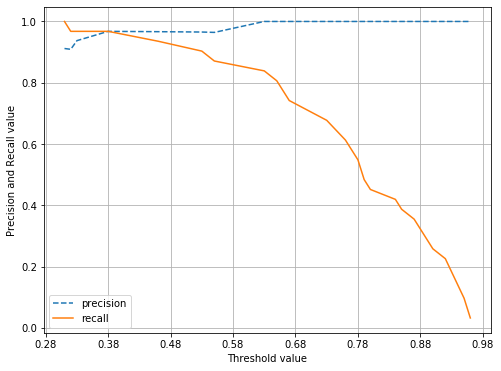

In [17]:
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test, pred_proba_c1):

    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    thresholds_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0: thresholds_boundary], linestyle= '--', label='precision')
    plt.plot(thresholds, recalls[0: thresholds_boundary], label='recall')
    
    stard, end = plt.xlim()
    plt.xticks(np.round(np.arange(stard, end, 0.1), 2))

    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, final.predict_proba(X_test)[:,1])

### ROC Curve

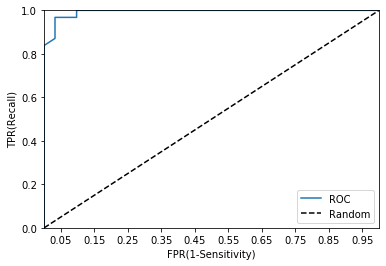

In [18]:
from sklearn.metrics import roc_curve

def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds  = roc_curve(y_test, pred_proba_c1)
    
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0,1], [0,1], 'k--', label='Random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR(1-Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:, 1])

### Feature importance

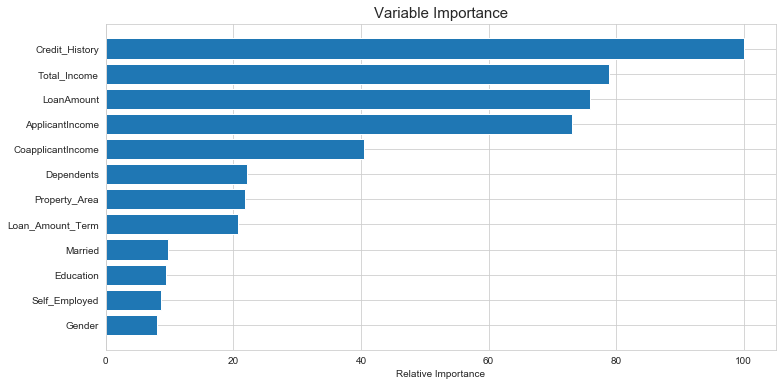

In [19]:
def plot_feature_importance(model, X_train, figsize=(12, 6)):
    
    sns.set_style('whitegrid')

    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=figsize)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance', fontsize=15)
    plt.show()

plot_feature_importance(final, X_train)